# Imports

In [1]:
from ebay_delivery_prediction_project import preprocessing, Visualisation, preprocessing_models, postprocessing
preprocessing.import_test()

from datetime import datetime, timedelta

Preprocessing successfully imported.


In [2]:
import numpy as np
import pandas as pd

In [3]:
training_data = preprocessing.read_data(rows_to_read = 1000)["train"]
print(training_data.columns)

Reading 1000 rows.
Reading all columns.
Index(['b2c_c2c', 'seller_id', 'declared_handling_days',
       'acceptance_scan_timestamp', 'shipment_method_id', 'shipping_fee',
       'carrier_min_estimate', 'carrier_max_estimate', 'item_zip', 'buyer_zip',
       'category_id', 'item_price', 'quantity', 'payment_datetime',
       'delivery_date', 'weight', 'weight_units', 'package_size',
       'record_number'],
      dtype='object')


# Basic Preprocessing

In [4]:
training_data = preprocessing.basic_preprocessing(training_data)

In [5]:
training_data["categorical_seller_ids"] = training_data["seller_id"].apply(lambda col: str(col)) 

In [6]:
print(training_data.columns)

Index(['b2c_c2c', 'seller_id', 'declared_handling_days',
       'acceptance_scan_timestamp', 'shipment_method_id', 'shipping_fee',
       'carrier_min_estimate', 'carrier_max_estimate', 'item_zip', 'buyer_zip',
       'category_id', 'item_price', 'quantity', 'payment_datetime',
       'delivery_date', 'weight', 'weight_units', 'package_size',
       'record_number', 'delivery_calendar_days', 'cleaned_item_zip',
       'cleaned_buyer_zip', 'categorical_seller_ids'],
      dtype='object')


## delivery_date

In [7]:
training_data = preprocessing.expand_datetime(df = training_data, date_column="delivery_date")

In [8]:
training_data["delivery_date_weekday"].value_counts()

Monday       224
Thursday     215
Friday       177
Wednesday    157
Saturday     157
Tuesday       68
Sunday         2
Name: delivery_date_weekday, dtype: int64

Insights : 
1. Packages almost never deliver on sunday.
2. Packages rarely deliver on Tuesday.

**Weekday is very important.**

## Payment Datetime

In [9]:
training_data = preprocessing.expand_datetime(df = training_data, date_column="payment_datetime")

In [10]:
training_data["delivery_date"][8].isocalendar()

(2019, 42, 2)

In [11]:
training_data["payment_datetime_weekday"].value_counts()

Monday       167
Friday       157
Thursday     149
Sunday       141
Wednesday    139
Saturday     126
Tuesday      121
Name: payment_datetime_weekday, dtype: int64

## delivery_calendar_days

<AxesSubplot:xlabel='delivery_calendar_days', ylabel='Count'>

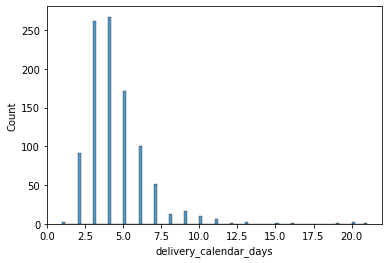

In [12]:
import seaborn as sns

sns.histplot(training_data, x = "delivery_calendar_days", bins = 100)

In [13]:
training_data.shape

(1000, 33)

In [14]:
(training_data["delivery_calendar_days"]>14).sum()

6

In [15]:
(training_data["delivery_calendar_days"]<2).sum()

3

**We need to treat the data in buckets.** The one percent of orders that are arriving after 20 days are almost certainly poisoning the data.

Also we need an internal loss testing tool to see the improvements we get.

## Next declared_handling_days

In [16]:
training_data.isnull().sum()

b2c_c2c                          0
seller_id                        0
declared_handling_days          15
acceptance_scan_timestamp        0
shipment_method_id               0
shipping_fee                     0
carrier_min_estimate             0
carrier_max_estimate             0
item_zip                         0
buyer_zip                        0
category_id                      0
item_price                       0
quantity                         0
payment_datetime                 0
delivery_date                    0
weight                           0
weight_units                     0
package_size                     0
record_number                    0
delivery_calendar_days           0
cleaned_item_zip                 0
cleaned_buyer_zip                0
categorical_seller_ids           0
delivery_date_year               0
delivery_date_month              0
delivery_date_week               0
delivery_date_weekday            0
delivery_date_day_of_year        0
payment_datetime_yea

### Seeing where declared_handling_days is Null

In [17]:
null_declared_handling_days_data = training_data[training_data["declared_handling_days"].isna()]
declared_handling_days_data = training_data[training_data["declared_handling_days"].notna()]

In [18]:
declared_handling_days_data.shape, null_declared_handling_days_data.shape

((985, 33), (15, 33))

In [19]:
declared_handling_days_data["declared_handling_days"].describe()

count    985.000000
mean       1.204061
std        1.445481
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       30.000000
Name: declared_handling_days, dtype: float64

In [20]:
len(null_declared_handling_days_data["seller_id"].unique()), len(declared_handling_days_data["seller_id"].unique())

(14, 571)

In [21]:
from tqdm import tqdm
from collections import defaultdict

In [22]:
all_sellers = defaultdict(lambda : False)

In [23]:
for seller in declared_handling_days_data["seller_id"].unique():
    all_sellers[seller] = True
#     print(seller)

for seller in null_declared_handling_days_data["seller_id"].unique():
    if all_sellers[seller] == True:
        pass
#         print(seller)

- From this you can tell that there are a lot of sellers who have declared handling days for some transactions and have not declared them for other transactions

Now need to see if there's any correlation between handling days and seller ID

In [24]:
training_data["categorical_seller_ids"] = training_data["seller_id"].apply(lambda col: str(col)) 

<AxesSubplot:xlabel='categorical_seller_ids', ylabel='declared_handling_days'>

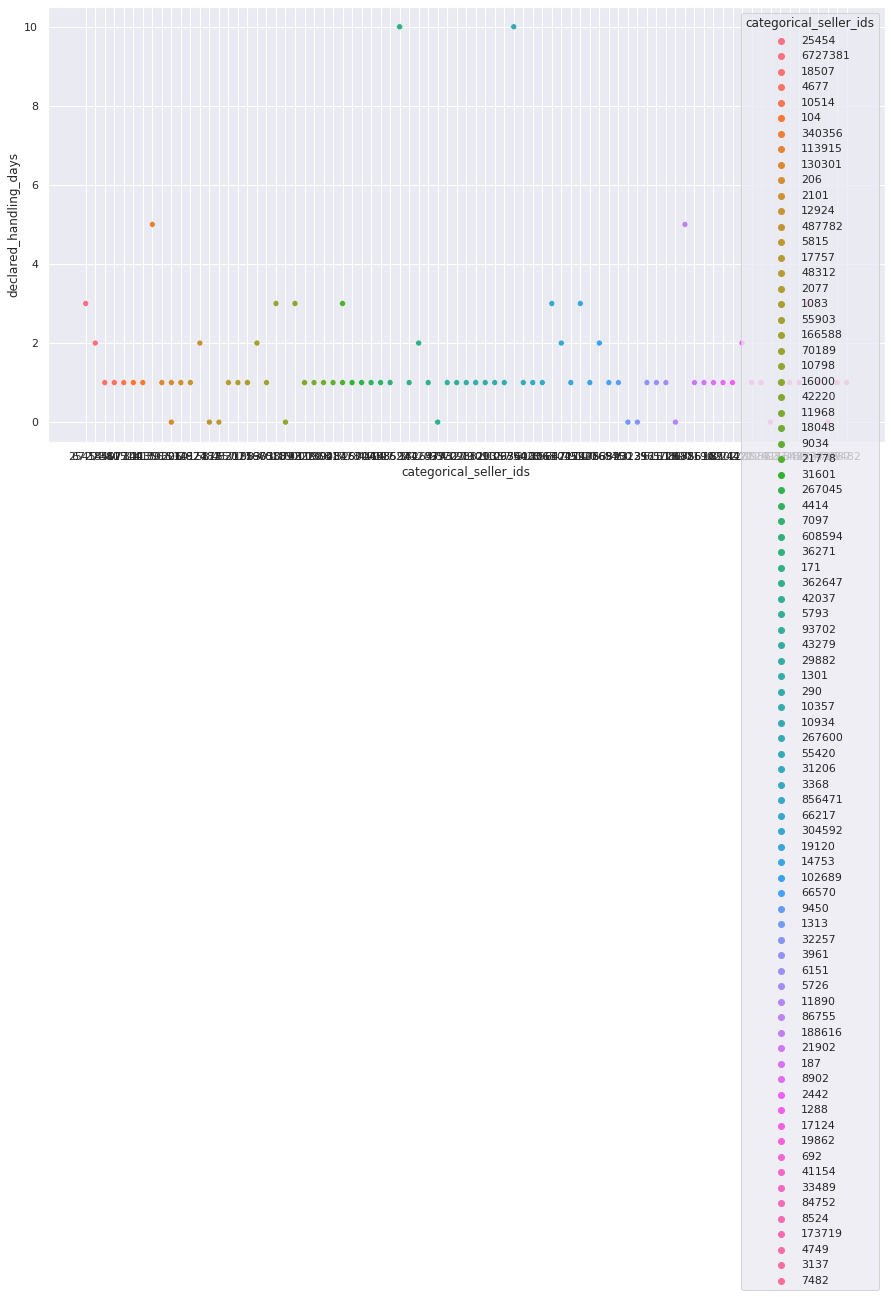

In [25]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})

sample_data = training_data[:100]

sns.scatterplot(data=sample_data, x=sample_data["categorical_seller_ids"], y='declared_handling_days', hue='categorical_seller_ids')


Need to see each seller and the days they give for handling.

In [26]:
for seller in tqdm(declared_handling_days_data["categorical_seller_ids"].unique()):
    sellers_data = declared_handling_days_data[declared_handling_days_data["categorical_seller_ids"] == seller]
    if len(sellers_data["declared_handling_days"].unique()) > 1:
        print(seller)
        break

  2%|▉                                                             | 9/571 [00:00<00:00, 1830.15it/s]

206


In [27]:
declared_handling_days_data[declared_handling_days_data["categorical_seller_ids"] == "206"]["declared_handling_days"].describe()

count    9.000000
mean     0.444444
std      0.527046
min      0.000000
25%      0.000000
50%      0.000000
75%      1.000000
max      1.000000
Name: declared_handling_days, dtype: float64

### Results
This shows that independent sellers can declare different handling days for different transactions.

# Zip codes

## Notes
The nine digits of a ZIP+4 code (e.g.,12345-6789) may be grouped as follows: [123] [45] [67] [89]

    [123] :  Sectional Center or Large City
    [45] : Post Office facility or Delivery Area
    [ - ] : The required "dash" or "hyphen" separates the first five digits from the last four digits; the +4
    [67] : Sector or Several Blocks
    [89] : Segment or One Side of a Street
    
The basic preprocessing for cleaning is done. Next if plotting the locations of these pincodes on a map.

In [28]:
import pgeocode
pgeocode.__version__

'0.3.0'

In [29]:
dist = pgeocode.GeoDistance('us')

pd.notna(dist.query_postal_code("65459", "04268"))

True

In [30]:
training_data.columns

Index(['b2c_c2c', 'seller_id', 'declared_handling_days',
       'acceptance_scan_timestamp', 'shipment_method_id', 'shipping_fee',
       'carrier_min_estimate', 'carrier_max_estimate', 'item_zip', 'buyer_zip',
       'category_id', 'item_price', 'quantity', 'payment_datetime',
       'delivery_date', 'weight', 'weight_units', 'package_size',
       'record_number', 'delivery_calendar_days', 'cleaned_item_zip',
       'cleaned_buyer_zip', 'categorical_seller_ids', 'delivery_date_year',
       'delivery_date_month', 'delivery_date_week', 'delivery_date_weekday',
       'delivery_date_day_of_year', 'payment_datetime_year',
       'payment_datetime_month', 'payment_datetime_week',
       'payment_datetime_weekday', 'payment_datetime_day_of_year'],
      dtype='object')

In [31]:
for _, row in tqdm(training_data.iterrows()):
    if pd.isna(dist.query_postal_code(row["cleaned_buyer_zip"], row["cleaned_item_zip"])):
        print("dest_zip : ", row["buyer_zip"], " source_zip : ", row["item_zip"])

270it [00:05, 47.63it/s]

dest_zip :  0  source_zip :  76537


325it [00:07, 47.67it/s]

dest_zip :  0  source_zip :  01863


570it [00:12, 46.65it/s]

dest_zip :  0  source_zip :  15213


605it [00:13, 46.95it/s]

dest_zip :  0  source_zip :  24520


770it [00:16, 47.75it/s]

dest_zip :  0  source_zip :  47396
dest_zip :  0  source_zip :  91801


810it [00:17, 46.89it/s]

dest_zip :  13417  source_zip :  00627


840it [00:18, 46.89it/s]

dest_zip :  98284  source_zip :  518000


920it [00:19, 45.71it/s]

dest_zip :  30268  source_zip :  518000
dest_zip :  4357  source_zip :  510420


975it [00:21, 47.15it/s]

dest_zip :  29520  source_zip :  610000
dest_zip :  72206  source_zip :  610000


1000it [00:21, 46.30it/s]


In [32]:
training_data.columns

Index(['b2c_c2c', 'seller_id', 'declared_handling_days',
       'acceptance_scan_timestamp', 'shipment_method_id', 'shipping_fee',
       'carrier_min_estimate', 'carrier_max_estimate', 'item_zip', 'buyer_zip',
       'category_id', 'item_price', 'quantity', 'payment_datetime',
       'delivery_date', 'weight', 'weight_units', 'package_size',
       'record_number', 'delivery_calendar_days', 'cleaned_item_zip',
       'cleaned_buyer_zip', 'categorical_seller_ids', 'delivery_date_year',
       'delivery_date_month', 'delivery_date_week', 'delivery_date_weekday',
       'delivery_date_day_of_year', 'payment_datetime_year',
       'payment_datetime_month', 'payment_datetime_week',
       'payment_datetime_weekday', 'payment_datetime_day_of_year'],
      dtype='object')

In [34]:
def pin_codes_dist(pin_1, pin_2):
    return dist.query_postal_code(pin_1, pin_2)

dist = pgeocode.GeoDistance('us')

training_data["distance_between_pincodes"] = training_data.apply(lambda row: pin_codes_dist(row["cleaned_buyer_zip"]
                                                                                            ,row["cleaned_item_zip"]), axis = 1)

In [5]:
training_data[training_data["distance_between_pincodes"].isna()][["item_zip", "buyer_zip"]]

,item_zip,buyer_zip
261,76537,0
318,01863,0
561,15213,0
597,24520,0
760,47396,0
769,91801,0
802,00627,13417
835,518000,98284
915,518000,30268
918,510420,4357


Places where distance is nan look bizzare anyway.